In [2]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed


In [3]:
import nltk

In [2]:
pip install wordcloud


     ------------------------------------ 153.1/153.1 kB 222.8 kB/s eta 0:00:00


In [3]:
pip install nltk


     ---------------------------------------- 1.5/1.5 MB 990.4 kB/s eta 0:00:00
     -------------------------------------- 267.8/267.8 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 96.6/96.6 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install -q contractions==0.0.48


In [6]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:20]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not
ain't == are not
aren't == are not
'cause == because
can't == can not
can't've == can not have
could've == could have
couldn't == could not
couldn't've == could not have
daren't == dare not
daresn't == dare not


In [7]:
# # Using TPU

# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [8]:
pwd

'C:\\Users\\Dell\\OneDrive\\Desktop\\Data Science Project\\text_summarization'

# Getting The Data

In [10]:
filename = './Dataset.csv'

df1 = pd.read_csv(filename, encoding='iso-8859-1').reset_index(drop=True)


In [11]:
df1.drop('Unnamed: 1', inplace=True, axis=1)

In [12]:
df1.drop('Unnamed: 3', inplace=True, axis=1)

In [13]:
df1=df1.iloc[:296]

In [14]:
df1.sample(7)

,Input_Text,Source,Summary
108,Meghalaya Chief Minister and National People's...,https://www.ndtv.com/india-news/meghalaya-chie...,Conrad K Sangma filed his nomination papers fo...
176,"Forty MLAs, comprising 22 per cent of the Asse...",https://www.ndtv.com/india-news/in-gujarat-16-...,40 MLAs have declared criminal cases against t...
24,Alleging that the BJP-led government is not fo...,https://www.ndtv.com/india-news/pm-restless-ov...,"Commenting on the Tripura elections, Congress ..."
241,Congress General Secretary Priyanka Gandhi Vad...,https://www.ndtv.com/india-news/congress-leade...,Priyanka Gandhi Vadra will take the final call...
82,Seizures totalling over Rs 147 crore have been...,https://www.ndtv.com/india-news/massive-rise-i...,Seizures worth over Rs 147 crore have been rec...
234,Bahujan Samaj Party (BSP) chief Mayawati on Su...,https://www.ndtv.com/india-news/after-bjps-ram...,Mayawati attributed the defeat of the Samajwad...
229,Union Home Minister Amit Shah has targeted the...,https://www.ndtv.com/india-news/new-parties-ca...,"Amit Shah has targeted the Aam Aadmi Party, sa..."


In [15]:
print(f'Dataset size: {len(df1)}')

Dataset size: 296


# Data Preparation

In [16]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [17]:
df1.sample(3)

,Input_Text,Source,Summary
269,"""I had said during the campaign in Gujarat tha...",https://www.ndtv.com/india-news/gujarat-assemb...,PM Modi congratulated Bhupendra Patel for brea...
79,Voting for the 60-member Tripura Assembly is s...,https://www.ndtv.com/india-news/2023-tripura-a...,The Tripura Assembly election will be held tom...
109,The Election Commission (EC) on Friday suspend...,https://www.ndtv.com/india-news/election-body-...,The EC suspended a sub-divisional police offic...


In [18]:
# Converting to lowercase
df1.loc[:, "Input_Text"] = df1["Input_Text"].str.lower()
df1.loc[:, "Summary"] = df1["Summary"].str.lower()

df1.sample(3)

,Input_Text,Source,Summary
86,bjp president j p nadda on tuesday asserted th...,https://www.ndtv.com/india-news/solution-to-na...,bjp president j p nadda said the solution to t...
38,a three-cornered high voltage election campaig...,https://www.ndtv.com/india-news/tripura-all-se...,the high voltage election campaign for tripura...
8,argentina broke records for heat and cold with...,https://www.ndtv.com/world-news/heatwave-to-sn...,argentina experienced record-breaking heat fol...


In [19]:
print(type(df1.iloc[2]["Input_Text"]))

<class 'str'>


In [20]:

df1['Input_Text'].apply(lambda x: isinstance(x, str))
df1['Summary'].apply(lambda x: isinstance(x, str))
df1.sample(5)

,Input_Text,Source,Summary
64,ãâ bjp's meteoric rise: the party had never...,https://www.ndtv.com/india-news/tripura-electi...,the bjp's success in tripura is attributed to ...
255,the bharatiya janata party (bjp) has won the l...,https://www.ndtv.com/india-news/bjp-wins-gujar...,the bharatiya janata party (bjp) has won the l...
184,mr sukhu was born into a humble rural family. ...,https://www.ndtv.com/india-news/5-facts-on-suk...,mr sukhu was born into a humble rural family a...
286,the aam aadmi party (aap) and the asaduddin ow...,https://www.ndtv.com/india-news/gujarat-aap-ai...,the aam aadmi party (aap) and the asaduddin ow...
190,around 25 cabinet ministers will also take an ...,https://www.ndtv.com/india-news/gujarat-electi...,"the bjp won a landslide victory in gujarat, wi..."


In [23]:
df1 = df1.dropna()


In [24]:
# Removing rows with empty cell
print(f'Dataset size: {len(df1)}')

Dataset size: 290


In [25]:
df1.Input_Text = df1.Input_Text.apply(expand_contractions)
df1.Summary = df1.Summary.apply(expand_contractions)
df1.sample(5)

,Input_Text,Source,Summary
47,the 2023 meghalaya assthembly election will wi...,https://www.ndtv.com/india-news/2023-meghalaya...,multi-cornered contests in meghalaya and tripu...
290,the aam aadmi party (aap) and the asaduddin ow...,https://www.ndtv.com/india-news/gujarat-aap-ai...,the aam aadmi party (aap) and the asaduddin ow...
125,the bjp will contest on all 60 seats of the me...,https://www.ndtv.com/india-news/bjp-to-contest...,the bjp will contest the meghalaya and nagalan...
269,"""i had said during the campaign in gujarat tha...",https://www.ndtv.com/india-news/gujarat-assemb...,pm modi congratulated bhupendra patel for brea...
19,the congress in meghalaya alleged that the rul...,https://www.ndtv.com/india-news/meghalaya-poll...,congress alleges npp failed to protect women a...


In [26]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [27]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [30]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [31]:
df1.loc[:, "Input_Text"] = df1["Input_Text"].apply(clean_text)
df1.loc[:, "Summary"] = df1["Summary"].apply(clean_text)


df1.sample(5)

,Input_Text,Source,Summary
202,jds leadership saturday named former chief min...,https://www.ndtv.com/karnataka-news/karnataka-...,jds named nikhil kuswamy candidate assthembly ...
210,tripura chief minister manik saha opted rather...,https://www.ndtv.com/india-news/tripura-chief-...,tripura chief minister manik saha gone doortod...
197,urging party workers ensure bjp forms governme...,https://www.ndtv.com/india-news/bjp-to-contest...,amit shah asserted bjp go alone karnataka asst...
287,samajwadi party candidate dimple yadav prestig...,https://www.ndtv.com/india-news/watch-celebrat...,dimple yadav lok sabha seat mainpuri two lakh ...
267,congress victory northern state seen silver li...,https://www.ndtv.com/india-news/congress-sachi...,congress victory himachal seen silver lining b...


In [32]:
df1.to_csv('cleaned_data.csv')

In [34]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

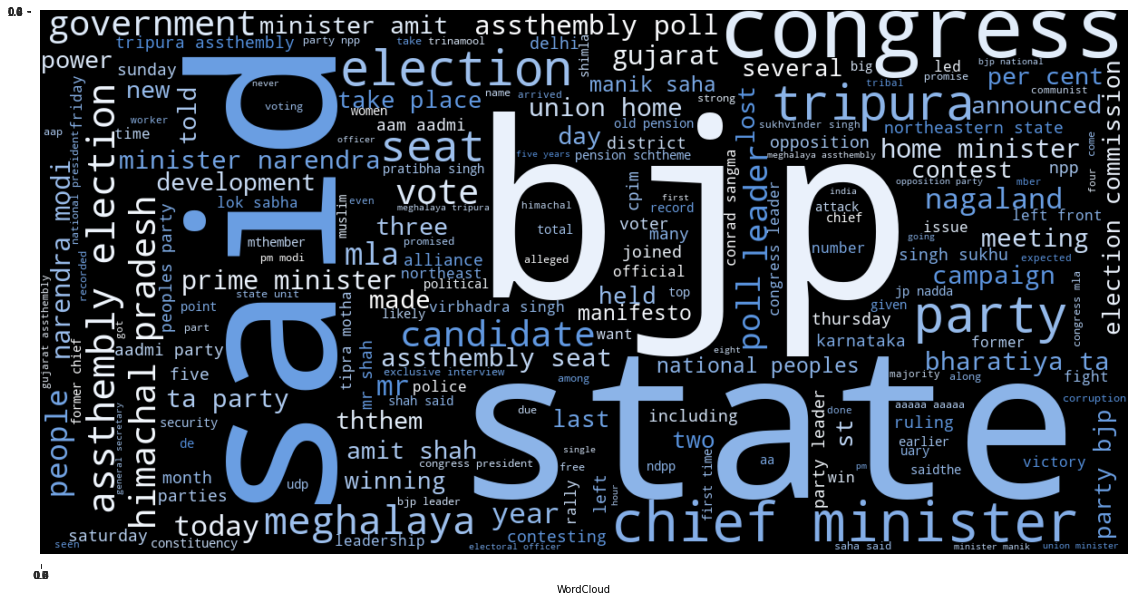

In [35]:
plot_wordcloud(' '.join(df1.Input_Text.values.tolist()), wc_blue_color_func)

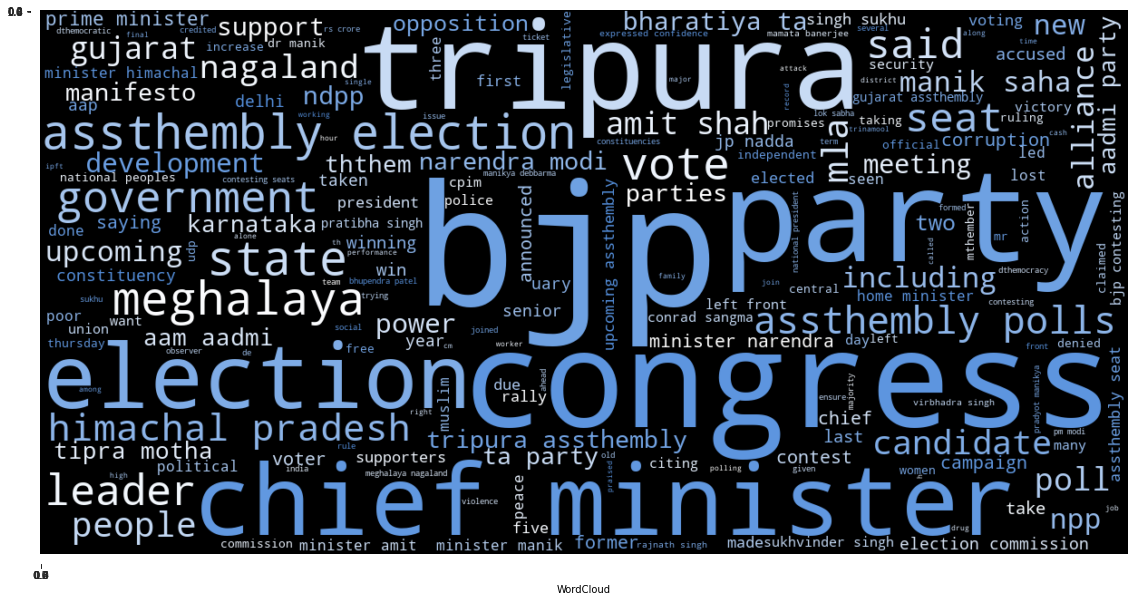

In [36]:
plot_wordcloud(' '.join(df1.Summary.values.tolist()), wc_blue_color_func)

In [58]:
df1.Input_Text = df1.Input_Text.apply(lambda x: f'_START_ {x} _END_')

In [59]:
df1.Summary = df1.Summary.apply(lambda x: f'_START_ {x} _END_')

In [38]:
df1.iloc[2]["Input_Text"]

'_START_ union housing urban affairs ministry ded take properties delhi waqf board including mosques dargahs graveyards evoking sharp reaction board chairman aap mla amanatullah khanmr khan asserted allow central government take waqf propertiesthe deputy land development officer letter board uary informed sion absolve matters pertaining waqf propertiesthe land development office ldo central ministry said twomthember committee headed justice retired sp garg issue denotified waqf properties report submitted representation objection received delhi waqf board _END_'

In [ ]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

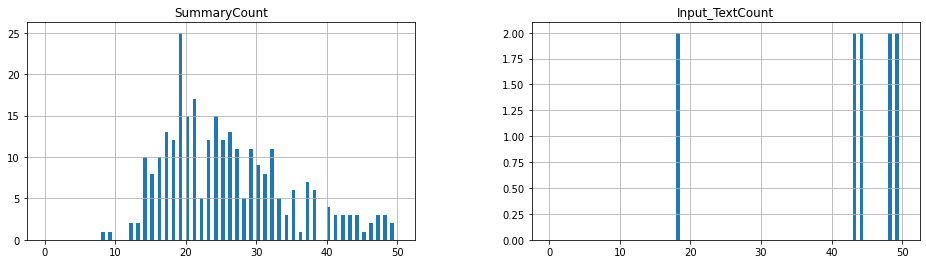

In [41]:
SummaryCount = [len(sentence.split()) for sentence in df1.Summary]
Input_TextCount = [len(sentence.split()) for sentence in df1.Input_Text]

pd.DataFrame({'SummaryCount': SummaryCount, 'Input_TextCount': Input_TextCount}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [54]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-100 words
print(get_word_percent(df1.Input_Text, 100))

# Check how many % of summary have 0-30 words
print(get_word_percent(df1.Summary, 35))

0.98
0.83


In [55]:
max_input_text_len = 100
max_summary_len = 35


In [57]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_input_text_len, max_summary_len):
    cleaned_text = np.array(df['Input_Text'])
    cleaned_summary = np.array(df['Summary'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_input_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df2 = trim_text_and_summary(df1, max_input_text_len, max_summary_len)
print(f'Original Dataset size: {len(df1)}')
print(f'After Dataset size: {len(df2)}')
df2.sample(5)


Original Dataset size: 290
After Dataset size: 237


,text,summary
202,_START_ urging party workers ensure bjp forms ...,amit shah asserted bjp go alone karnataka asst...
81,_START_ choosing bjp guarantee development und...,choosing bjp guarantee development prime minis...
226,_START_ sign growing trouble congress victory ...,party workers himachal pradesh blocked convoy ...
201,_START_ himachal pradesh deputy chief minister...,mukesh agnihotri sukhvinder sukhu taken oath n...
90,_START_ bjp contest seats meghalaya assthembly...,bjp contest meghalaya nagaland elections campa...
